<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_Calif_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Libs

In [38]:
!pip install -q import_ipynb lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [39]:
# utils
import os, sys, warnings, itertools, tarfile
import import_ipynb
import pandas as pd
import numpy as np
# colab
from google.colab import drive
# lime
import lime
import lime.lime_tabular
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.compose import (ColumnTransformer, make_column_transformer)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
# vis
import seaborn as sns
import matplotlib.pyplot as plt

### Settings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [7]:
# module dir
module_path = os.path.abspath(os.path.join("./"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
# load MachineLearningUtils module
from MachineLearningUtils import *

## Process Data

#### Load Data

In [9]:
data_dir = "california_housing"

In [10]:
HOUSING_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, data_dir=data_dir): # fetch data
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)
    tgz_path = os.path.join(data_dir, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=data_dir)
    housing_tgz.close()
    print(f"Dataset downloaded to {data_dir}")

fetch_housing_data()

Dataset downloaded to california_housing


In [11]:
print(os.listdir(data_dir))

['housing.tgz', 'housing.csv']


In [12]:
def load_housing_data(data_dir=data_dir):
    csv_path = os.path.join(data_dir, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

#### Understand Data

In [13]:
reduce_memory_usage(df=housing, category=True)

Memory usage of dataframe is 1.574829 MB!
Memory usage after optimization is 0.413685 MB!
Decreased by 73.7%


In [14]:
summarize_columns(housing)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,longitude,float16,0,0.0,155,-122.25,-122.25,-122.25
1,latitude,float16,0,0.0,301,37.875,37.875,37.84375
2,housing_median_age,float16,0,0.0,52,41.0,21.0,52.0
3,total_rooms,float16,0,0.0,4076,880.0,7100.0,1467.0
4,total_bedrooms,float16,207,1.0,1904,129.0,1106.0,190.0
5,population,float16,0,0.0,3234,322.0,2400.0,496.0
6,households,float16,0,0.0,1803,126.0,1138.0,177.0
7,median_income,float16,0,0.0,3275,8.328125,8.304688,7.257812
8,median_house_value,float32,0,0.0,3842,452600.0,358500.0,352100.0
9,ocean_proximity,category,0,0.0,5,NEAR BAY,NEAR BAY,NEAR BAY


In [15]:
display_df(housing)

Dataframe:  
num_rows = 20,640 
num_cols = 10


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.25,37.87500,41.0,880.0,129.0,322.0,126.0,8.328125,452600.0,NEAR BAY
1,-122.25,37.87500,21.0,7100.0,1106.0,2400.0,1138.0,8.304688,358500.0,NEAR BAY
2,-122.25,37.84375,52.0,1467.0,190.0,496.0,177.0,7.257812,352100.0,NEAR BAY
3,-122.25,37.84375,52.0,1274.0,235.0,558.0,219.0,5.644531,341300.0,NEAR BAY
4,-122.25,37.84375,52.0,1627.0,280.0,565.0,259.0,3.845703,342200.0,NEAR BAY


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float16 
 1   latitude            20640 non-null  float16 
 2   housing_median_age  20640 non-null  float16 
 3   total_rooms         20640 non-null  float16 
 4   total_bedrooms      20433 non-null  float16 
 5   population          20640 non-null  float16 
 6   households          20640 non-null  float16 
 7   median_income       20640 non-null  float16 
 8   median_house_value  20640 non-null  float32 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float16(8), float32(1)
memory usage: 423.6 KB
Number of null data points:
total_bedrooms    207
dtype: int64


In [16]:
cols = list(housing.columns)
categorical_features = ["ocean_proximity"]
numerical_features = [col for col in cols if col not in categorical_features]

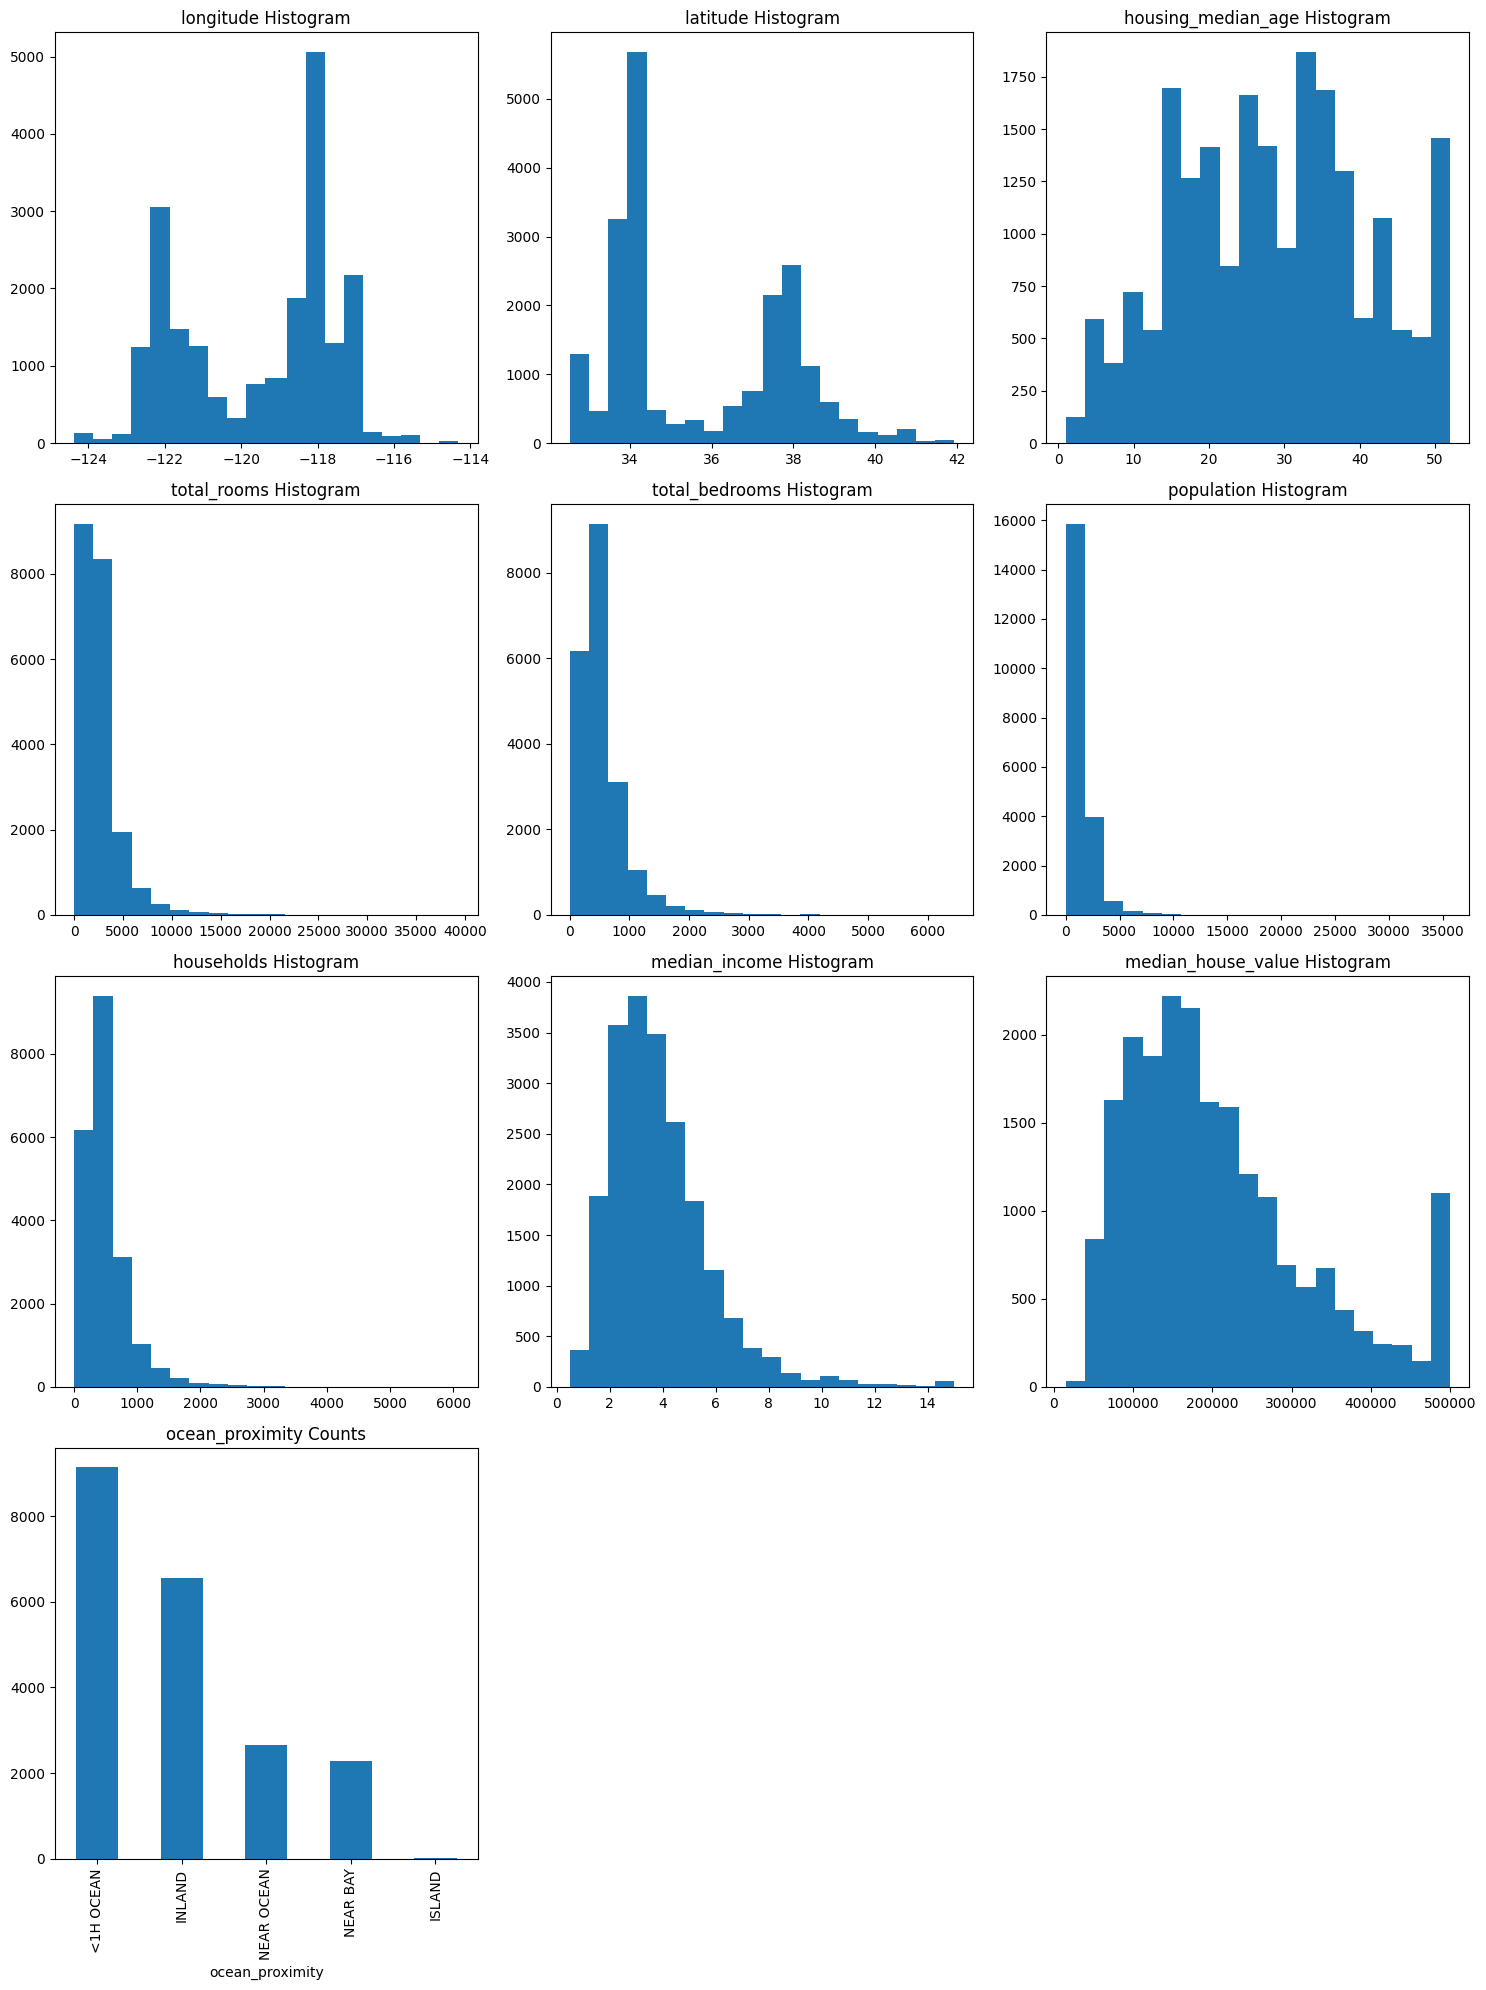

In [17]:
plot_variables(df=housing, vars_to_plot=cols, cts_vars=numerical_features, num_cols=3, hist_num_bins=20)

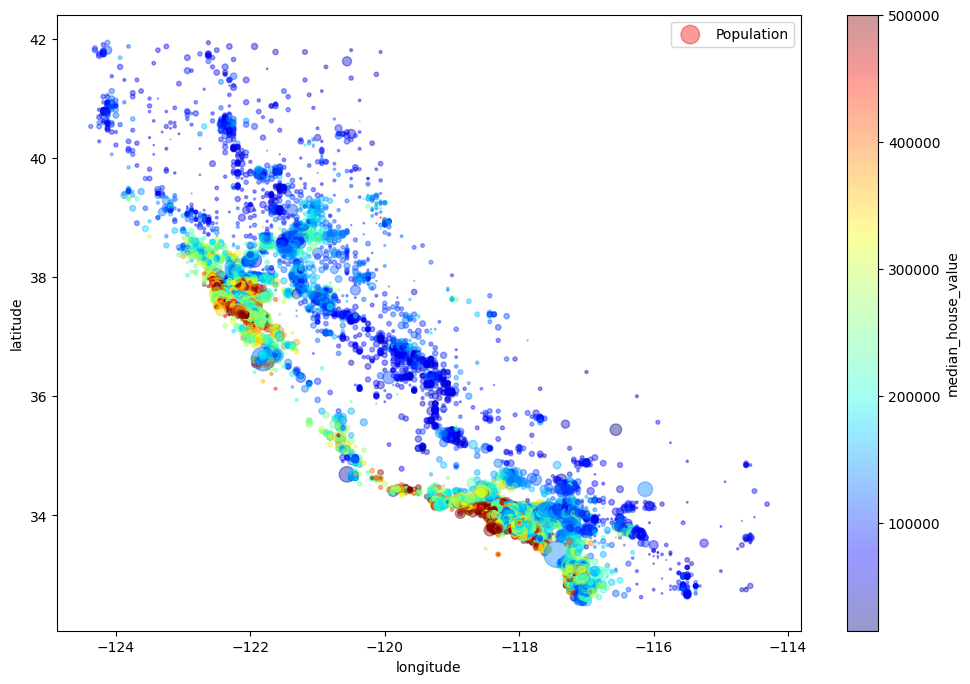

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(12,8), alpha=0.4,
             s=housing["population"]/100., label="Population", c="median_house_value",
             cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

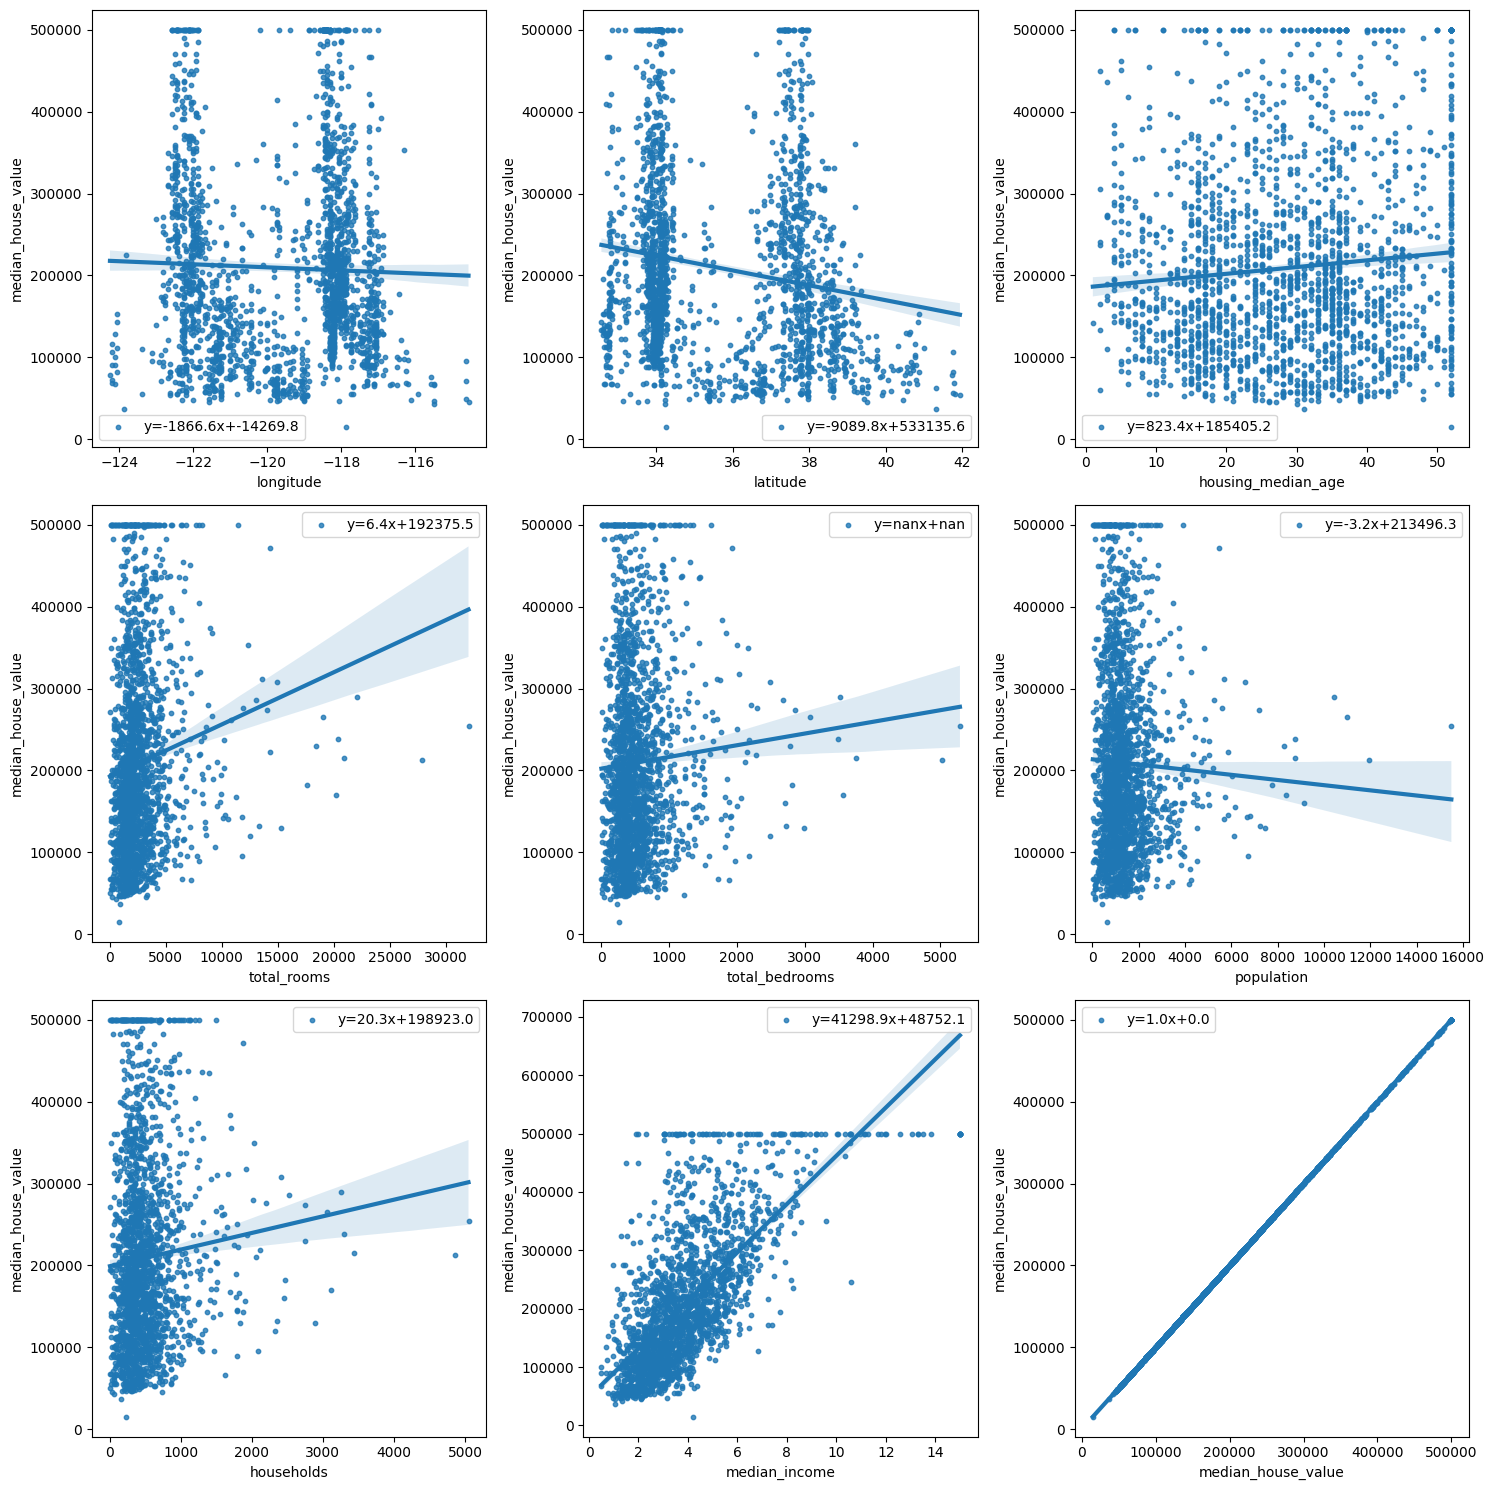

In [19]:
reg_sample = housing.sample(frac=0.1)
plot_regs(df=reg_sample, cts_vars=numerical_features , response="median_house_value",
          num_cols=3, dot_size=10, line_width=3)

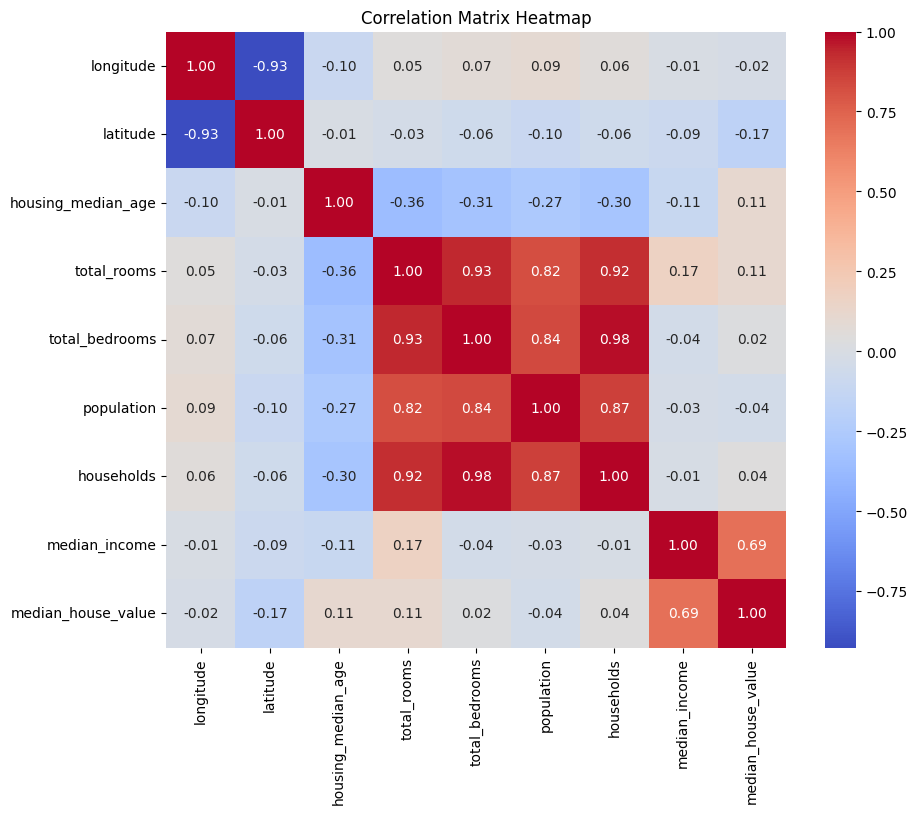

In [20]:
train_df, test_df = train_test_split(housing, test_size=0.2, random_state=42)
sample_train_df = train_df.sample(frac=0.2)
sample_train_df.drop("ocean_proximity", axis=1, inplace=True)
corr_matrix = sample_train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [21]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.693499
total_rooms,0.111460
housing_median_age,0.109238
households,0.038645
total_bedrooms,0.022180
longitude,-0.018636
population,-0.043627
latitude,-0.170248


#### Impute Data

In [22]:
# load data
housing = load_housing_data()

In [23]:
# iomputers
simple_imputer = SimpleImputer(strategy="median")
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
standard_scaler = StandardScaler()

In [24]:
imputer = simple_imputer.fit_transform(housing[numerical_features])
train_df_num = pd.DataFrame(imputer, columns=numerical_features)
display_df(train_df_num)

Dataframe:  
num_rows = 20,640 
num_cols = 9


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [25]:
one_hot_enc = one_hot_encoder.fit_transform(housing[categorical_features])
train_df_cat = pd.DataFrame(one_hot_enc, columns=one_hot_encoder.get_feature_names_out())
display_df(train_df_cat)

Dataframe:  
num_rows = 20,640 
num_cols = 5


,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ocean_proximity_<1H OCEAN   20640 non-null  float64
 1   ocean_proximity_INLAND      20640 non-null  float64
 2   ocean_proximity_ISLAND      20640 non-null  float64
 3   ocean_proximity_NEAR BAY    20640 non-null  float64
 4   ocean_proximity_NEAR OCEAN  20640 non-null  float64
dtypes: float64(5)
memory usage: 806.4 KB


#### Features Engineering

In [26]:
if 'attribs' in locals() or 'attribs' in globals():
    del attribs
if 'housing_with_extra_attr' in locals() or 'housing_with_extra_attr' in globals():
    del housing_with_extra_attr

class AppendRatioVariables(BaseEstimator, TransformerMixin):

    def __init__(self, hash_ix):
        self.hash_ix = hash_ix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        hash_ix = self.hash_ix
        rooms_per_household = X[:, hash_ix["total_rooms"]]/X[:, hash_ix["households"]]
        population_per_household = X[:, hash_ix["population"]]/X[:, hash_ix["households"]]
        bedrooms_per_rooms = X[:, hash_ix["total_bedrooms"]]/X[:, hash_ix["households"]]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_rooms]

col_names = ["total_rooms", "total_bedrooms", "population", "households"]
col_indices = [housing.columns.get_loc(col) for col in col_names]
hash_indexes = dict(zip(col_names, col_indices))

attribs = AppendRatioVariables(hash_indexes)
X_with_extra_attribs = attribs.fit_transform(housing)
cols = list(housing.columns) + ["rooms_per_household", "bedrooms_per_rooms", "population_per_household"]

housing_with_extra_attr = pd.DataFrame(X_with_extra_attribs, columns=cols)
display_df(housing_with_extra_attr)

Dataframe:  
num_rows = 20,640 
num_cols = 13


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_rooms,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556,1.02381
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842,0.97188
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,2.80226,1.073446
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,2.547945,1.073059
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,2.181467,1.081081


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   longitude                 20640 non-null  object
 1   latitude                  20640 non-null  object
 2   housing_median_age        20640 non-null  object
 3   total_rooms               20640 non-null  object
 4   total_bedrooms            20433 non-null  object
 5   population                20640 non-null  object
 6   households                20640 non-null  object
 7   median_income             20640 non-null  object
 8   median_house_value        20640 non-null  object
 9   ocean_proximity           20640 non-null  object
 10  rooms_per_household       20640 non-null  object
 11  bedrooms_per_rooms        20640 non-null  object
 12  population_per_household  20433 non-null  object
dtypes: object(13)
memory usage: 2.0+ MB
Number of null data points:
total_

Alternative Implementation
```
class AppendRatioVariables(BaseEstimator, TransformerMixin):
    def __init__(self, ratios=None, col_names=None):
        self.ratios = ratios
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            _X = pd.DataFrame(X, columns=self.col_names)
        else:
            _X = X.copy()
        if self.ratios is not None:
            for ratio in self.ratios:
                _X[ratio[0]] = _X[ratio[1]]/_X[ratio[2]]
        return _X

ratios = [["rooms_per_household", "total_rooms", "households"],
          ["bedrooms_per_rooms", "total_bedrooms", "total_rooms"],
          ["population_per_household", "population", "households"]]

attribs = _AppendRatioVariables(ratios)
housing_with_extra_attr = attribs.fit_transform(housing)
display_df(housing_with_extra_attr) *italicized text*
```



#### Main Pipelines For Preprocessing

In [27]:
num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                               ("attribs_embedder", AppendRatioVariables(hash_indexes)),
                               ("std_scaler", StandardScaler())
                              ]
                       )
cat_pipeline = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")),
                               ("one_hot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
                              ]
                       )
data_processor_pipeline = ColumnTransformer([("num", num_pipeline, numerical_features),
                                             ("cat", cat_pipeline, categorical_features)
                                            ]
                                           )
data = data_processor_pipeline.fit_transform(housing)


extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
one_hot_attribs = list(data_processor_pipeline.named_transformers_["cat"].get_feature_names_out())
attribs = numerical_features + extra_attribs + one_hot_attribs
df = pd.DataFrame(data, columns=attribs)
display_df(df)

Dataframe:  
num_rows = 20,640 
num_cols = 17


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,2.129631,0.628559,-0.049597,-0.148514,0.0,0.0,0.0,1.0,0.0
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,1.314156,0.327041,-0.092512,-0.248542,0.0,0.0,0.0,1.0,0.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.258693,1.155620,-0.025843,-0.052902,0.0,0.0,0.0,1.0,0.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,1.165100,0.156966,-0.050329,-0.053647,0.0,0.0,0.0,1.0,0.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,1.172900,0.344711,-0.085616,-0.038196,0.0,0.0,0.0,1.0,0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   rooms_per_household         20640 non-null  float64
 10  population_per_household    20640 non-null  float64
 11  bedrooms_per_room           20640 non-null  float64
 12  ocean_proximity_<1H OCEAN   20640 non-null  float64
 13  ocean_proximity_INLAND   

## ML Models

In [28]:
y = df[["median_house_value"]]
X = df.drop("median_house_value", axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
def eval_reg_model(X_data, X_test, y_data, y_test, model):
    model.fit(X_data, y_data)
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    model_name = type(model).__name__
    print("model: {},  rmse = {:.2f}, mae = {:.2f}, r2 = {:.2f}".format(model_name, rmse, mae, r2))

In [30]:
eval_reg_model(X_train, X_valid, y_train, y_valid, LinearRegression())
eval_reg_model(X_train, X_valid, y_train, y_valid, DecisionTreeRegressor())
eval_reg_model(X_train, X_valid, y_train, y_valid, SVR(kernel="linear"))
eval_reg_model(X_train, X_valid, y_train, y_valid, RandomForestRegressor())

model: LinearRegression,  rmse = 0.60, mae = 0.43, r2 = 0.64
model: DecisionTreeRegressor,  rmse = 0.60, mae = 0.39, r2 = 0.64
model: SVR,  rmse = 0.60, mae = 0.42, r2 = 0.63
model: RandomForestRegressor,  rmse = 0.43, mae = 0.28, r2 = 0.81


In [31]:
search_space = {
    "n_estimators": [100, 200],
    "max_features": [4, 6],
    "max_depth": [4, 5]
}
forest_reg = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=forest_reg, param_grid=search_space,
                           cv=5, scoring="r2", return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)
eval_reg_model(X_train, X_valid, y_train, y_valid, grid_search.best_estimator_)

{'max_depth': 5, 'max_features': 6, 'n_estimators': 200}
RandomForestRegressor(max_depth=5, max_features=6, n_estimators=200,
                      random_state=0)
0.7005035769780757
model: RandomForestRegressor,  rmse = 0.55, mae = 0.40, r2 = 0.69


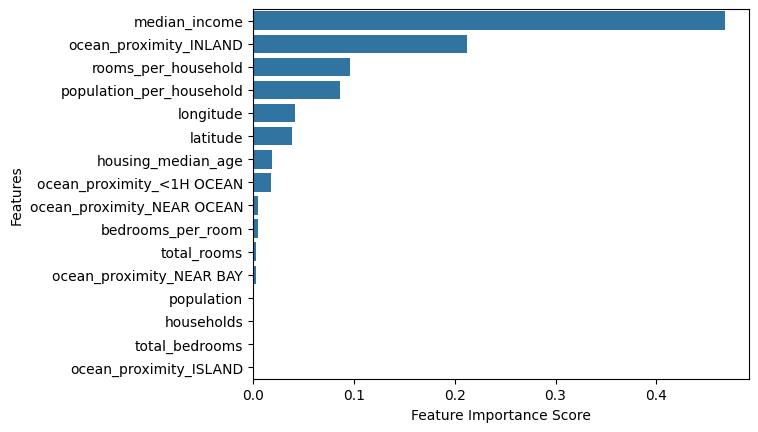

In [32]:
attribs.remove('median_house_value')
feature_importances = grid_search.best_estimator_.feature_importances_
feature_imp = pd.Series(feature_importances, index= attribs).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

In [52]:
explainer = lime.lime_tabular.LimeTabularExplainer(
       training_data=X_train.values,
       feature_names=X_train.columns,
       mode='regression'
   )

exp = explainer.explain_instance(
       data_row=X_valid.iloc[0].values,
       predict_fn=grid_search.best_estimator_.predict
   )

exp.show_in_notebook(show_table=True)

In [33]:
y_pred = grid_search.predict(X_valid)

In [34]:
mse = mean_squared_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

MSE: 0.3014622608398561
RMSE: 0.5490557902798732
MAE: 0.3988202681634007
R2: 0.6921579395329818


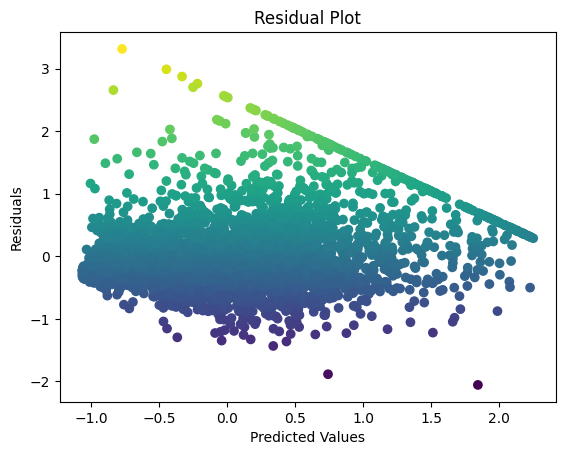

In [35]:
residuals = y_valid.to_numpy().flatten() - y_pred
plt.scatter(y_pred, residuals, c=residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [36]:
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=10, scoring='r2')
print("Cross-validation scores:", scores)
print("Average R2:", scores.mean())

Cross-validation scores: [0.33442814 0.71304661 0.55140088 0.45744044 0.64457643 0.64105836
 0.50611008 0.42829469 0.49493442 0.69390235]
Average R2: 0.546519239392083
